In [ ]:
from google.colab import files
files.upload()

Saving synthetic_financial_data.csv to synthetic_financial_data.csv


{'synthetic_financial_data.csv': b'transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description\n1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027\n2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053\n3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035\n4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037\n5,1036,2083,1890.1,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083\n6,1032,2021,8487.68,2023-01-01 00:00:05,1,American Express,City-1,Gas Station,43,Purchase at Merchant-2021\n7,1029,2033,7565.3,2023-01-01 00:00:06,1,Visa,City-7,Online Shopping,19,Purchase at Merchant-2033\n8,1018,2088,2284.88,2023-01-01 00:00:07,0,American Express,City-46,Travel,40,Purchase at Merchant-2088\n9,10

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import folium
from folium.plugins import MarkerCluster
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("synthetic_financial_data.csv")

In [ ]:
top_15_cities = [
    'New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix',
    'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'Austin',
    'Jacksonville', 'San Jose', 'Fort Worth', 'Columbus', 'Charlotte'
]
unique_city_codes = sorted(df['location'].unique())
repeated_cities = np.resize(top_15_cities, len(unique_city_codes))
city_map = dict(zip(unique_city_codes, repeated_cities))
df['city_name'] = df['location'].map(city_map)

In [ ]:
city_coordinates = {
    'New York': (40.7128, -74.0060),
    'Los Angeles': (34.0522, -118.2437),
    'Chicago': (41.8781, -87.6298),
    'Houston': (29.7604, -95.3698),
    'Phoenix': (33.4484, -112.0740),
    'Philadelphia': (39.9526, -75.1652),
    'San Antonio': (29.4241, -98.4936),
    'San Diego': (32.7157, -117.1611),
    'Dallas': (32.7767, -96.7970),
    'Austin': (30.2672, -97.7431),
    'Jacksonville': (30.3322, -81.6557),
    'San Jose': (37.3382, -121.8863),
    'Fort Worth': (32.7555, -97.3308),
    'Columbus': (39.9612, -82.9988),
    'Charlotte': (35.2271, -80.8431)
}

In [ ]:
df['city_name'].unique()

array([np.str_('Dallas'), np.str_('San Jose'), np.str_('Los Angeles'),
       np.str_('Fort Worth'), np.str_('New York'), np.str_('Chicago'),
       np.str_('Jacksonville'), np.str_('Austin'), np.str_('San Antonio'),
       np.str_('Phoenix'), np.str_('Houston'), np.str_('Columbus'),
       np.str_('Charlotte'), np.str_('Philadelphia'),
       np.str_('San Diego')], dtype=object)

In [ ]:
df[['latitude', 'longitude']] = df['city_name'].map(city_coordinates).apply(pd.Series)

In [ ]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 transaction_id             0
customer_id                0
merchant_id                0
amount                     0
transaction_time           0
is_fraudulent              0
card_type                  0
location                   0
purchase_category          0
customer_age               0
transaction_description    0
city_name                  0
latitude                   0
longitude                  0
dtype: int64


Fraud Distribution:
 is_fraudulent
1    0.5068
0    0.4932
Name: proportion, dtype: float64


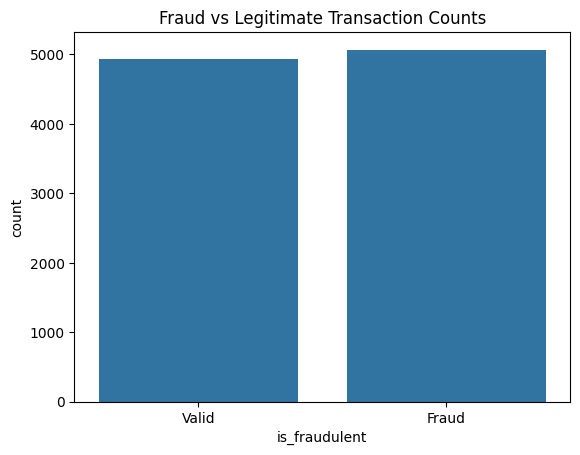

In [ ]:
fraud_counts = df['is_fraudulent'].value_counts(normalize=True)
print("Fraud Distribution:\n", fraud_counts)
sns.countplot(x='is_fraudulent', data=df)
plt.title("Fraud vs Legitimate Transaction Counts")
plt.xticks([0,1], ['Valid', 'Fraud'])
plt.show()

count    10000.000000
mean      4958.381617
std       2899.699675
min         10.610000
25%       2438.175000
50%       4943.945000
75%       7499.312500
max       9999.750000
Name: amount, dtype: float64


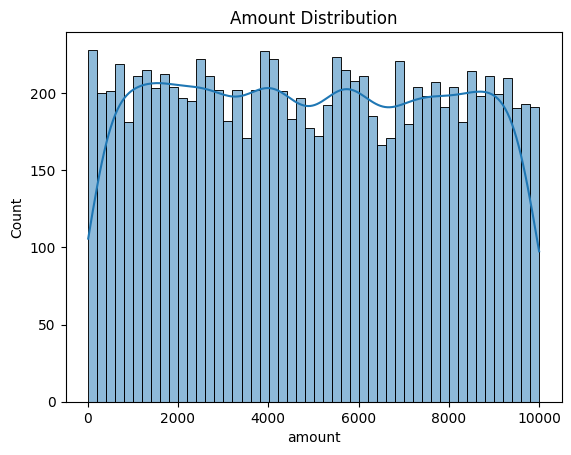

In [ ]:
print(df['amount'].describe())
sns.histplot(df['amount'], bins=50, kde=True)
plt.title("Amount Distribution")
plt.show()

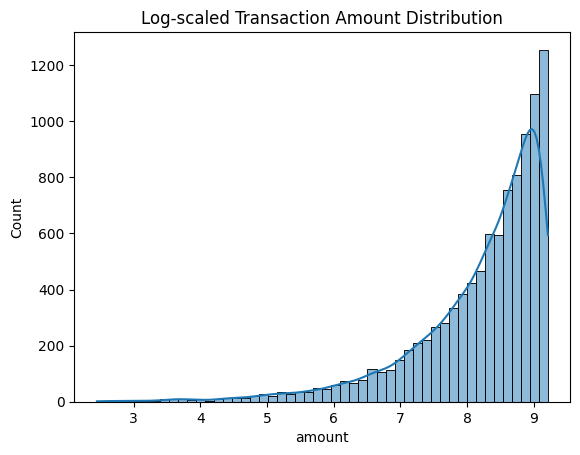

In [ ]:
sns.histplot(np.log1p(df['amount']), bins=50, kde=True)
plt.title("Log-scaled Transaction Amount Distribution")
plt.show()

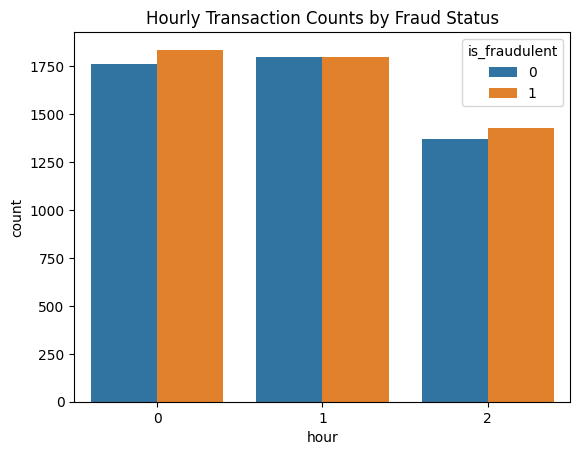

In [ ]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df['hour'] = df['transaction_time'].dt.hour
sns.countplot(data=df, x='hour', hue='is_fraudulent')
plt.title("Hourly Transaction Counts by Fraud Status")
plt.show()

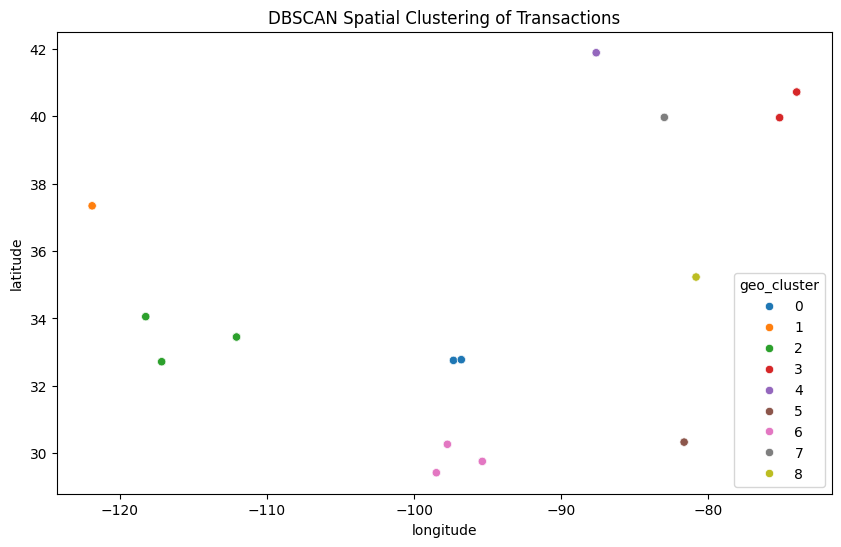

Fraud rate by cluster:
 geo_cluster
0.0    0.520536
1.0    0.504259
2.0    0.495917
3.0    0.529290
4.0    0.517900
5.0    0.473171
6.0    0.507864
7.0    0.511797
8.0    0.477966
Name: is_fraudulent, dtype: float64


In [ ]:
df_geo = df.dropna(subset=['latitude', 'longitude'])
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_geo[['latitude', 'longitude']])
db = DBSCAN(eps=0.5, min_samples=5).fit(coords_scaled)
df.loc[df_geo.index, 'geo_cluster'] = db.labels_
df_geo['geo_cluster'] = db.labels_

plt.figure(figsize=(10,6))
sns.scatterplot(x='longitude', y='latitude', hue='geo_cluster', data=df_geo, palette='tab10')
plt.title("DBSCAN Spatial Clustering of Transactions")
plt.show()

fraud_by_cluster = df.groupby('geo_cluster')['is_fraudulent'].mean()
print("Fraud rate by cluster:\n", fraud_by_cluster)

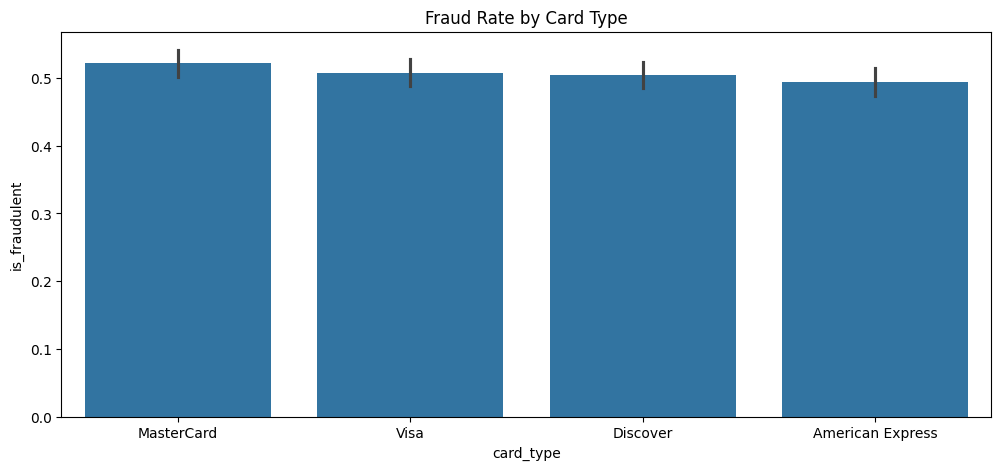

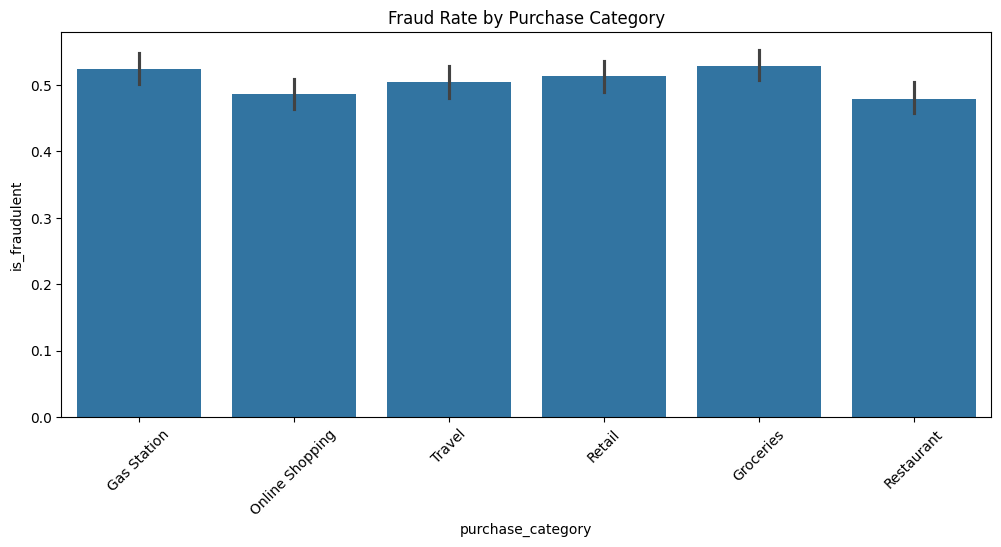

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(x='card_type', y='is_fraudulent', data=df, estimator=np.mean)
plt.title("Fraud Rate by Card Type")
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(x='purchase_category', y='is_fraudulent', data=df, estimator=np.mean)
plt.xticks(rotation=45)
plt.title("Fraud Rate by Purchase Category")
plt.show()

In [ ]:
map_center = [df['latitude'].mean(), df['longitude'].mean()]
fraud_map = folium.Map(location=map_center, zoom_start=5)
marker_cluster = MarkerCluster().add_to(fraud_map)

for idx, row in df.dropna(subset=['latitude', 'longitude']).iterrows():
    popup_text = f"City: {row['city_name']}<br>Fraudulent: {row['is_fraudulent']}<br>Amount: ${row['amount']:.2f}"
    color = 'red' if row['is_fraudulent'] else 'green'
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        popup=popup_text,
        color=color,
        fill=True,
        fill_color=color
    ).add_to(marker_cluster)

fraud_map.save("fraud_heatmap.html")
print("Folium fraud heatmap saved as fraud_heatmap.html")

Folium fraud heatmap saved as fraud_heatmap.html


In [ ]:
from google.colab import files
files.download("fraud_heatmap.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

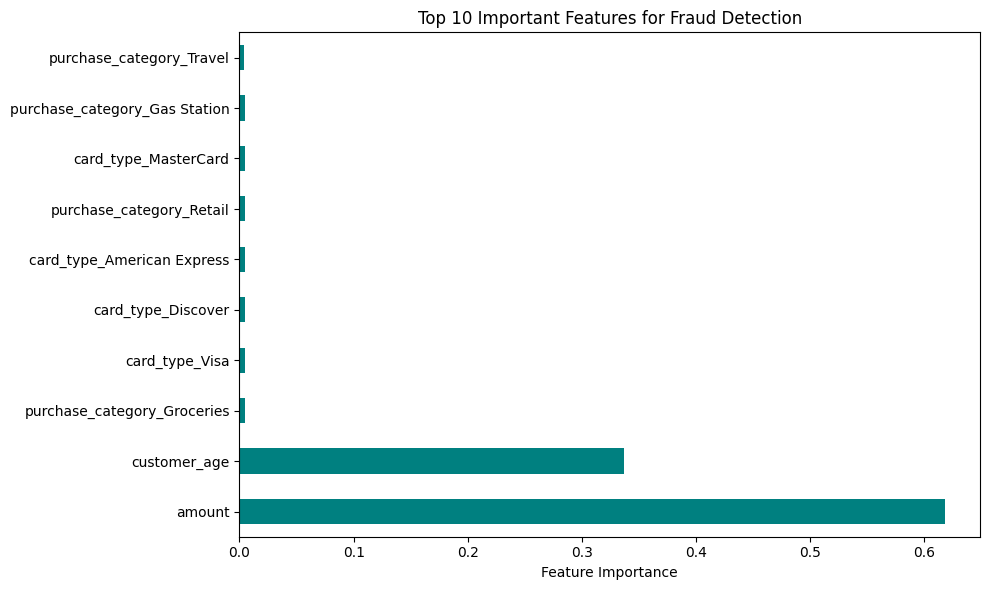

              precision    recall  f1-score   support

           0       0.49      0.53      0.51       966
           1       0.53      0.50      0.51      1034

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



In [31]:
cols_to_drop = ['is_fraudulent', 'transaction_time', 'transaction_id',
                'customer_id', 'merchant_id', 'location', 'transaction_description']
features = df.drop(columns=cols_to_drop)
features = pd.get_dummies(features)

features = features[[col for col in features.columns if 'purchase_category_Purchase at Merchant' not in col]]
labels = df['is_fraudulent']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=features.columns)
top_10 = importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_10.plot(kind='barh', color='teal')
plt.title("Top 10 Important Features for Fraud Detection")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()
preds = rf.predict(X_test)
print(classification_report(y_test, preds))


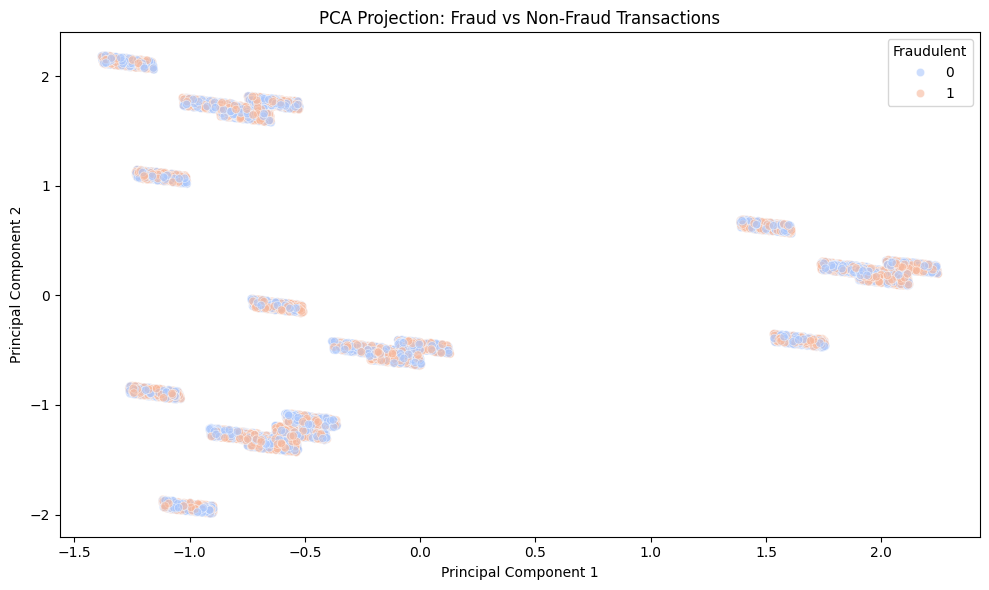

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['is_fraudulent'] = labels.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='is_fraudulent', palette='coolwarm', alpha=0.6)
plt.title("PCA Projection: Fraud vs Non-Fraud Transactions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Fraudulent')
plt.tight_layout()
plt.show()

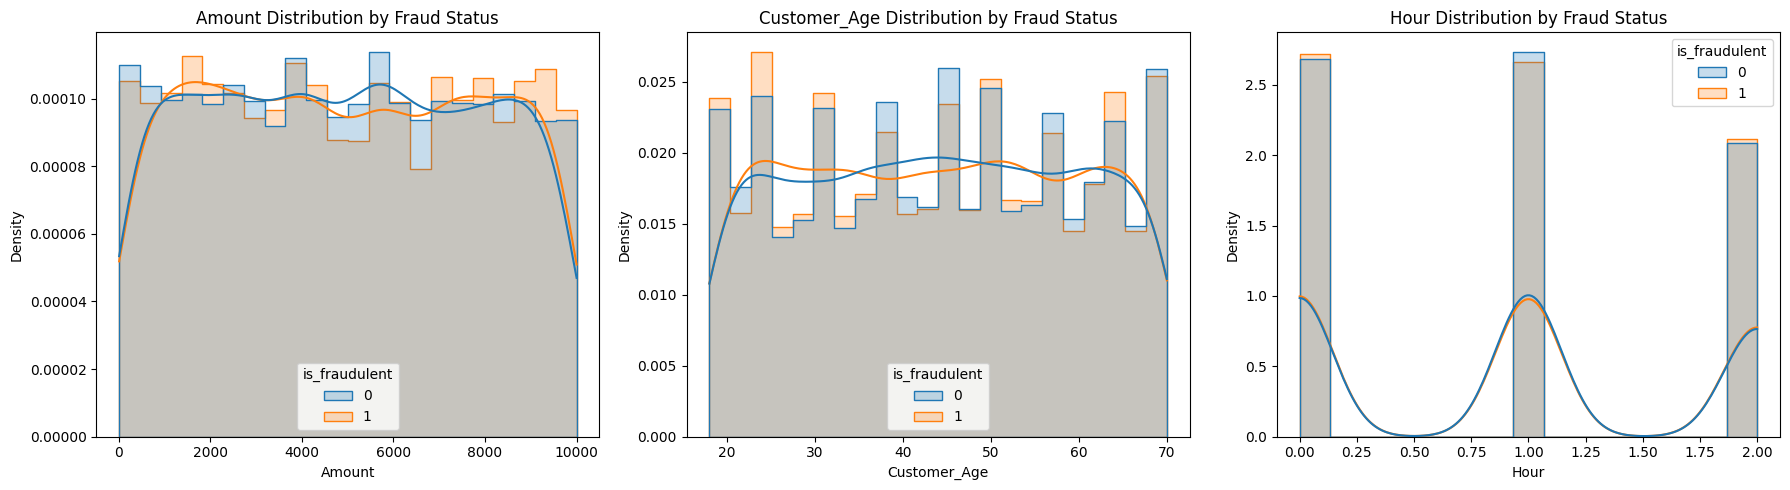

In [37]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'], errors='coerce')
df['hour'] = df['transaction_time'].dt.hour

# Convert label to numeric
df['is_fraudulent'] = pd.to_numeric(df['is_fraudulent'], errors='coerce')

# Select only available features
selected_features = ['amount', 'customer_age', 'hour']

# Plot histograms with KDE overlays
plt.figure(figsize=(18, 5))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df, x=feature, hue='is_fraudulent', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f"{feature.title()} Distribution by Fraud Status")
    plt.xlabel(feature.title())
    plt.ylabel("Density")

plt.tight_layout()
plt.show()

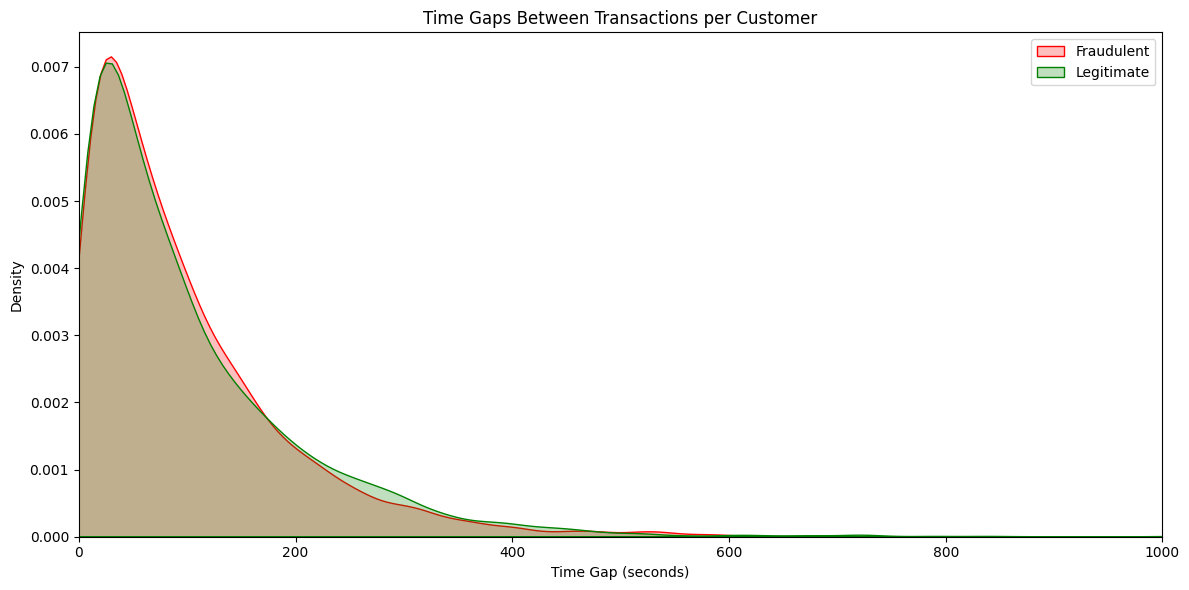

In [ ]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df_sorted = df.sort_values(['customer_id', 'transaction_time'])
df_sorted['time_diff'] = df_sorted.groupby('customer_id')['transaction_time'].diff().dt.total_seconds()
df_gap = df_sorted.dropna(subset=['time_diff'])

plt.figure(figsize=(12,6))
sns.kdeplot(data=df_gap[df_gap['is_fraudulent'] == 1], x='time_diff', label='Fraudulent', fill=True, color='red')
sns.kdeplot(data=df_gap[df_gap['is_fraudulent'] == 0], x='time_diff', label='Legitimate', fill=True, color='green')
plt.xlim(0, 1000)
plt.title("Time Gaps Between Transactions per Customer")
plt.xlabel("Time Gap (seconds)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


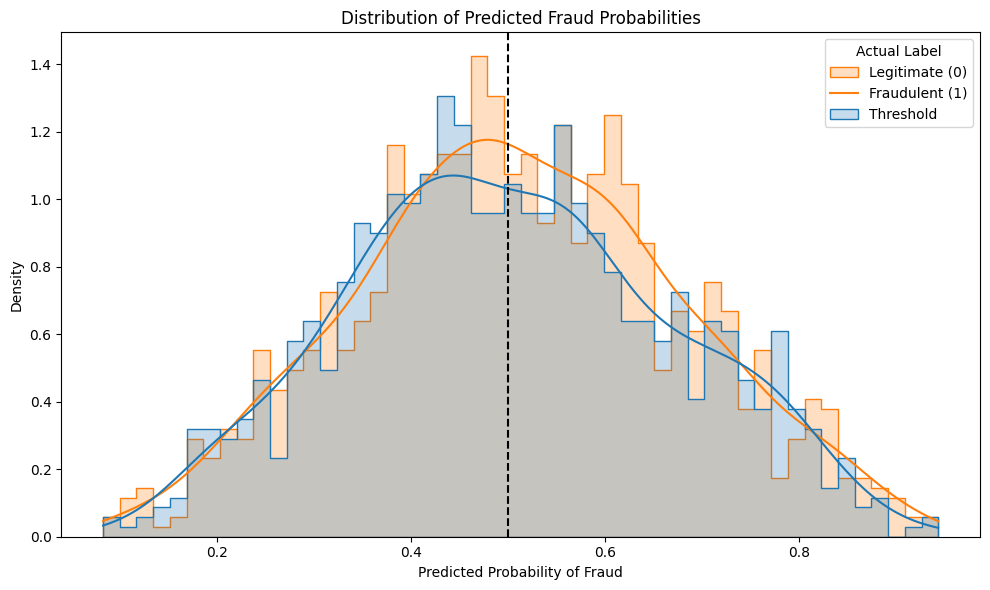

In [ ]:
features = df.drop(columns=['is_fraudulent', 'transaction_time'])
features = pd.get_dummies(features)
labels = df['is_fraudulent']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:, 1]

probs_df = pd.DataFrame({
    'probability': y_probs,
    'actual_label': y_test.reset_index(drop=True)
})


plt.figure(figsize=(10,6))
sns.histplot(data=probs_df, x='probability', hue='actual_label', bins=50, kde=True, element='step', stat='density')
plt.axvline(0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
plt.title("Distribution of Predicted Fraud Probabilities")
plt.xlabel("Predicted Probability of Fraud")
plt.ylabel("Density")
plt.legend(title='Actual Label', labels=['Legitimate (0)', 'Fraudulent (1)', 'Threshold'])
plt.tight_layout()
plt.show()


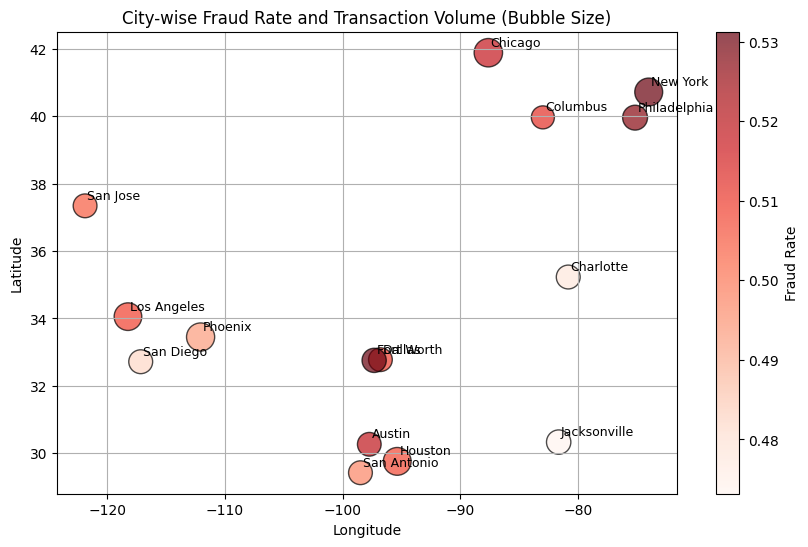

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    city_stats['longitude'],
    city_stats['latitude'],
    s=city_stats['transaction_count'] * 0.5,
    c=city_stats['fraud_rate'],
    cmap='Reds',
    alpha=0.7,
    edgecolors='black'
)
for i, row in city_stats.iterrows():
    plt.text(row['longitude'] + 0.2, row['latitude'] + 0.2, row['city_name'], fontsize=9)

plt.colorbar(scatter, label='Fraud Rate')
plt.title('City-wise Fraud Rate and Transaction Volume (Bubble Size)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

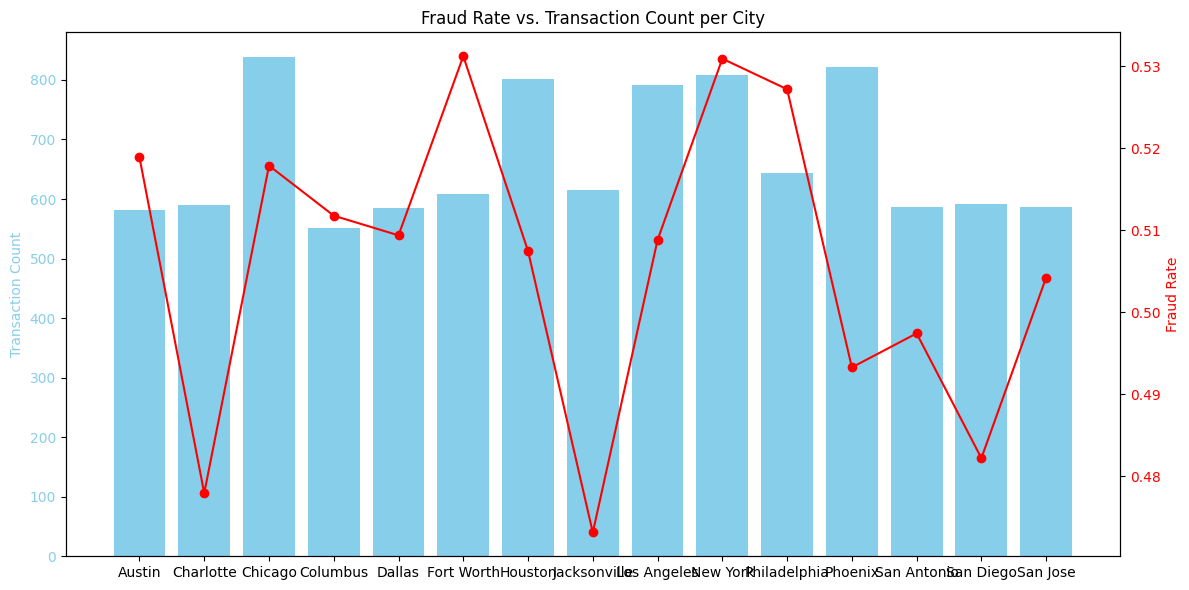

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(city_stats['city_name'], city_stats['transaction_count'], color='skyblue', label='Transaction Count')
ax1.set_ylabel('Transaction Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()
ax2.plot(city_stats['city_name'], city_stats['fraud_rate'], color='red', marker='o', label='Fraud Rate')
ax2.set_ylabel('Fraud Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Fraud Rate vs. Transaction Count per City')
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()


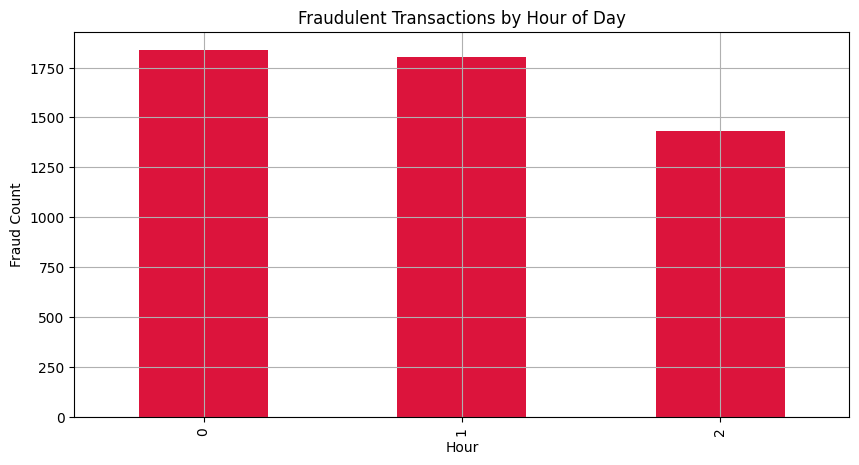

In [ ]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])

df['hour'] = df['transaction_time'].dt.hour
df['weekday'] = df['transaction_time'].dt.day_name()

plt.figure(figsize=(10, 5))
df[df['is_fraudulent'] == 1]['hour'].value_counts().sort_index().plot(kind='bar', color='crimson')
plt.title('Fraudulent Transactions by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Count')
plt.grid(True)
plt.show()

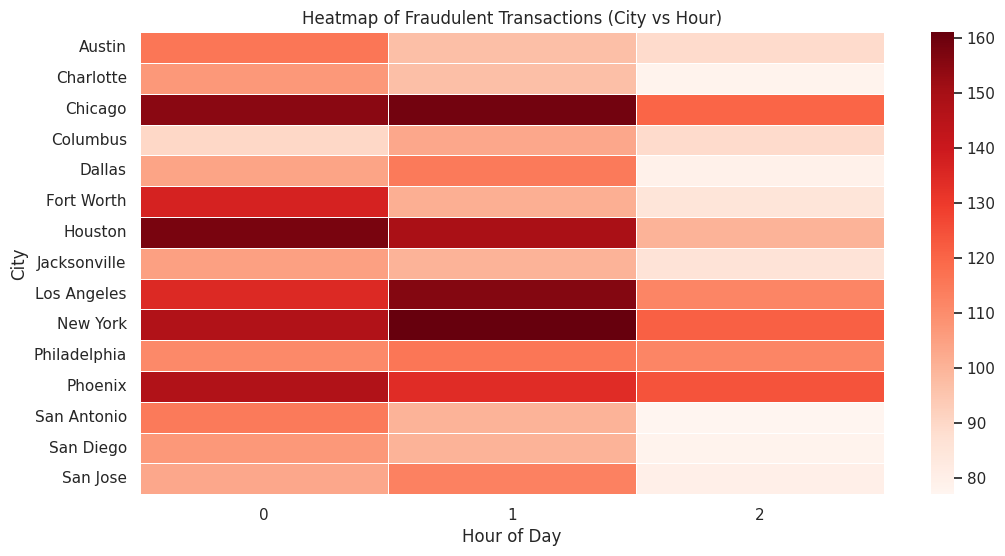

In [ ]:
heatmap_data = df[df['is_fraudulent'] == 1].groupby(['city_name', 'hour'])['is_fraudulent'].count().unstack().fillna(0)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5)
plt.title('Heatmap of Fraudulent Transactions (City vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('City')
plt.show()

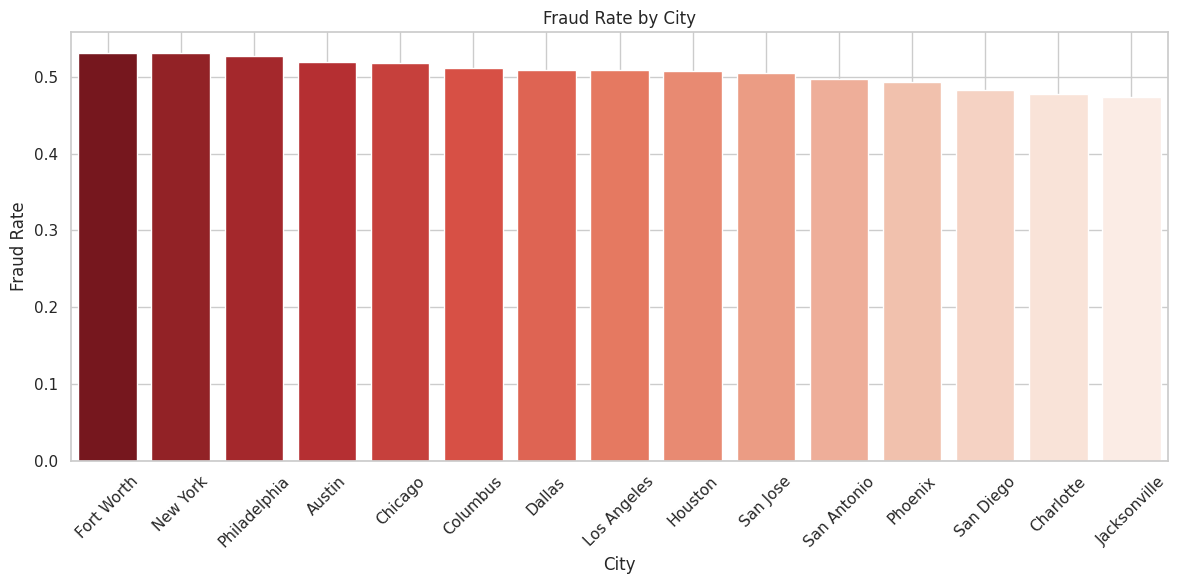

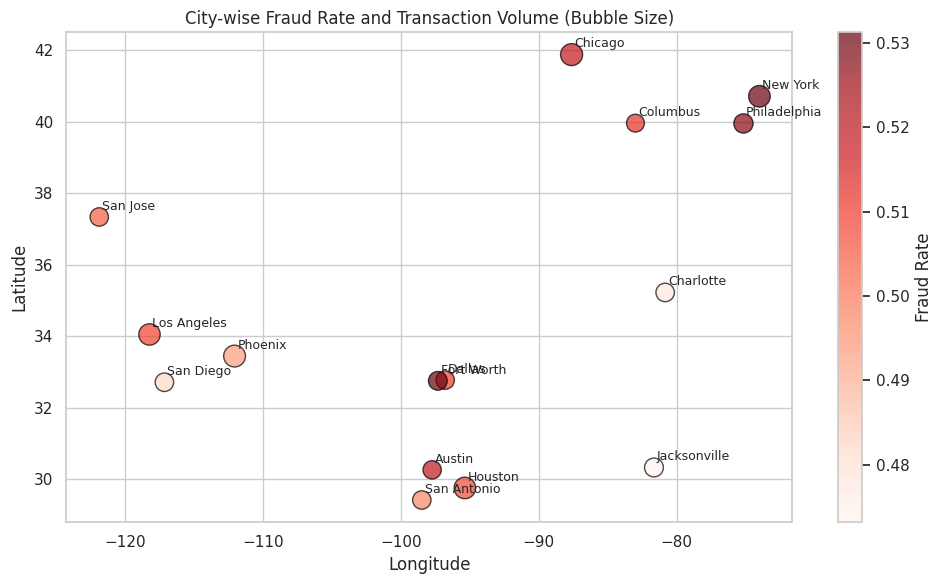

In [ ]:
df['city_name'] = df['location'].map(city_map)
df['latitude'] = df['city_name'].map(lambda x: city_coordinates.get(x, (None, None))[0])
df['longitude'] = df['city_name'].map(lambda x: city_coordinates.get(x, (None, None))[1])

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

city_stats = df.groupby('city_name').agg(
    transaction_count=('transaction_id', 'count'),
    fraud_count=('is_fraudulent', 'sum'),
    avg_amount=('amount', 'mean'),
    latitude=('latitude', 'first'),
    longitude=('longitude', 'first')
).reset_index()
city_stats['fraud_rate'] = city_stats['fraud_count'] / city_stats['transaction_count']

plt.figure(figsize=(12, 6))
sns.barplot(data=city_stats.sort_values('fraud_rate', ascending=False),
            x='city_name', y='fraud_rate', palette='Reds_r')
plt.title('Fraud Rate by City')
plt.xlabel('City')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    city_stats['longitude'],
    city_stats['latitude'],
    s=city_stats['transaction_count'] * 0.3,
    c=city_stats['fraud_rate'],
    cmap='Reds',
    alpha=0.7,
    edgecolors='black'
)
for i, row in city_stats.iterrows():
    plt.text(row['longitude'] + 0.2, row['latitude'] + 0.2, row['city_name'], fontsize=9)

plt.colorbar(scatter, label='Fraud Rate')
plt.title('City-wise Fraud Rate and Transaction Volume (Bubble Size)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()